In [0]:
## importing necessary libraries
import keras
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

from skimage.transform import resize
import cv2

import tensorflow as tf

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading CIFAR10 dataset and data preprocessing

In [0]:
## loading pre shuffled cifar10 dataset

from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

In [0]:
## for calculating the accuracy of the model

def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

In [0]:
## pixel normalisation

train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255

# convert class labels to binary class labels

train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

## Loading ResNet18 for imagenet and transferring it for CIFAR10

In [0]:
%cd /content/drive/My Drive/classification_models/resnet

/content/drive/My Drive/classification_models/resnet


In [0]:
import sys
sys.path.insert(0, '/content/drive/My Drive/classification_models/resnet')

### Building ResNet18 model 

In [0]:
## Building model
from builder import build_resnet
from utils import load_model_weights
from weights import weights_collection
from params import get_model_params

__all__ = ['ResNet18', 'ResNet34', 'ResNet50', 'ResNet101', 'ResNet152',
           'SEResNet18', 'SEResNet34', 'preprocess_input']

# preprocessing function
preprocess_input = lambda x: x


def _get_resnet(name):
    def classifier(input_shape, input_tensor=None, weights=None, classes=1000, include_top=True):
        model_params = get_model_params(name)
        model = build_resnet(input_tensor=input_tensor,
                             input_shape=input_shape,
                             classes=classes,
                             include_top=include_top,
                             **model_params)

        model.name = name

        if weights:
            load_model_weights(weights_collection, model, weights, classes, include_top)

        return model
    return classifier


# classic resnet models
ResNet18 = _get_resnet('resnet18')


### Loading weights and transferring model to classify CIFAR10

In [0]:
n_classes = 10

# build model
base_model = ResNet18(input_shape=(32,32,3), weights='imagenet', include_top=False)
x = Convolution2D(10, 1, 1)(base_model.output)
x = GlobalAveragePooling2D()(x)
output = Activation('softmax')(x)
model = keras.models.Model(inputs=[base_model.input], outputs=[output])

# train
model.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_features, train_labels)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(10, (1, 1))`
  """


Epoch 1/1
50000/50000 [==============================] - 54s 1ms/step - loss: 1.0014 - acc: 0.6565


In [0]:
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Accuracy on test data is: 76.04


In [0]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 32, 32, 3)    9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_235 (ZeroPadding (None, 38, 38, 3)    0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 16, 16, 64)   9408        zero_padding2d_235[0][0]         
__________________________________________________________________________________________________
bn0 (Batch

## Identifying misclassified images

In [0]:
## Making a set of 50 misclaffied images
image_index = []
c=0
for i in range(10000):
  actual = np.argmax(test_labels[i])
  img_test = test_features[i]
  img_reshaped = img_test.reshape((1, 32, 32, 3))
  preds = model.predict(img_reshaped)
  predicted = np.argmax(preds[0])
  if actual!=predicted:
    c+=1
    image_index.append(i)
  if c==50:
    break
  

## Implementing gradCAM

In [0]:
def gradCAM(model, img):
  img_reshaped = img.reshape((1, 32, 32, 3))
  
  ## getting the last activation layer of the model
  preds = model.predict(img_reshaped)
  class_idx = np.argmax(preds[0])
  class_output = model.output[:, class_idx]
  last_conv_layer = model.get_layer("stage2_unit1_relu1")
  
  ## getting the gradient
  grads = K.gradients(class_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate([img_reshaped])
  for i in range(64):    
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
    
  ## Making heatmap  
  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)                              ## (8, 8)
  
  heat3D = np.dstack((heatmap, heatmap, heatmap))         ## (8, 8, 3)
  
  patches = resize(heat3D, (32,32),  anti_aliasing=True)  ## (32, 32, 3)
  patches = np.uint8(255 * patches)                       ## unnormalized
  
  cv2.imwrite('patch.jpg', patches)
  patch = cv2.imread('patch.jpg', 0)
  
  patch_converted = cv2.cvtColor(patch, cv2.COLOR_GRAY2BGR)
  patches_colored = cv2.applyColorMap(patch_converted, cv2.COLORMAP_JET)
  
  img_unnorm = np.uint8(255 * img)
  
  ## blending images
  superimposed_img = cv2.addWeighted(img_unnorm, 0.7, patches_colored, 0.3, 0)
  
  return superimposed_img, class_idx
  

In [0]:
## Making lists of misclassified images and their gradCAMs with labels

images = []
images_label = []
grad_images = []
grad_label = []

for i, img_idx in enumerate(image_index):
  #print(i, img_idx)
  img_test = test_features[img_idx]
  
  images.append(img_test)
  images_label.append(np.argmax(test_labels[img_idx]))

  result, label = gradCAM(model, img_test)
  grad_images.append(result)
  grad_label.append(label)


## gradCAM visualization

In [0]:
## set of 50 misclassified images
img_num = len(image_index)

## Creating a list of the classes label for title purpose
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']


  ****** Misclassified Image and its gradCAM ******



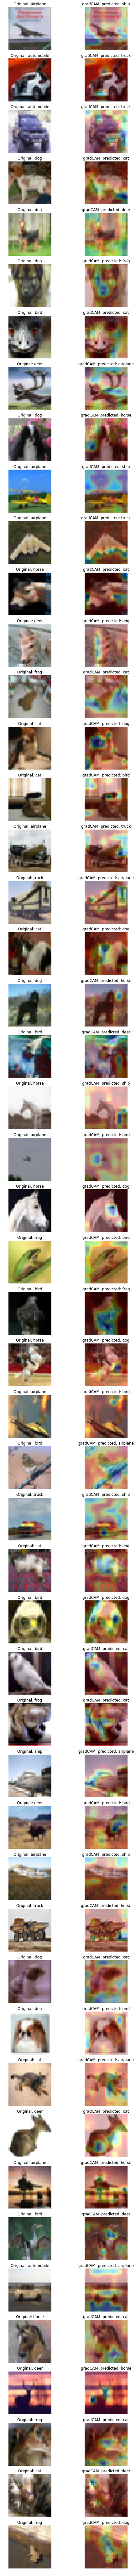

In [0]:
print('  ****** Misclassified Image and its gradCAM ******')
print()
plot = 0

ax = plt.figure(figsize=(8,150))
for i in range(img_num):
  
  plot+=1
  ax = plt.subplot(img_num, 2, plot)
  ax = plt.imshow(images[i])
  ax = plt.title(f"Original: {class_names[images_label[i]]}")
  ax = plt.axis('off')
  
  plot+=1
  ax = plt.subplot(img_num, 2, plot)
  ax = plt.imshow(grad_images[i])
  ax = plt.title(f"gradCAM  predicted: {class_names[grad_label[i]]}")
  ax = plt.axis('off')
